In [1]:
#Global variables
ROOT_DIR = '/content/src'
DATA_DIR = '/content/src/data'

# **Setup workspace** 

In [2]:
!nvidia-smi

Wed Jun 23 00:13:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!git clone https://github.com/nhtlongcs/simple-adversarial-attack src

Cloning into 'src'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 67 (delta 29), reused 48 (delta 17), pack-reused 0
Unpacking objects: 100% (67/67), done.


## Prepare data

In [4]:
%%capture
%cd $DATA_DIR
!chmod +x *.sh
!./download.sh

In [5]:
%cd $ROOT_DIR
!python scripts/neete2imnet.py data/imagenette2/train/
!python scripts/neete2imnet.py data/imagenette2/val/

/content/src


# Coding

### **Import libs**

In [6]:
%cd $ROOT_DIR

/content/src


In [7]:
import torchvision.utils
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from torchvision import models as torch_models

from modules import *

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

### **Load data**

In [9]:
%cd $ROOT_DIR

/content/src


In [10]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(), # ToTensor : [0, 255] -> [0, 1]
])

In [11]:
imgnet_dataset = image_folder_dataset(root = 'data/imagenette2/train/', transform = transform, idx2label = idx2label)
imgnet_dataloader = DataLoader(imgnet_dataset, batch_size=1, shuffle=False)

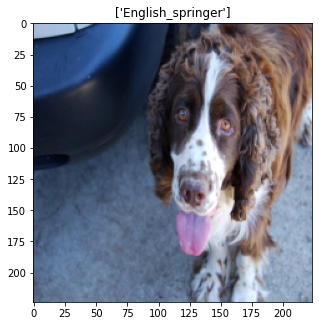

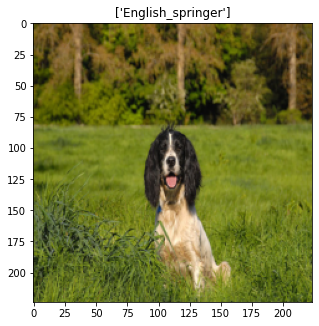

In [12]:
subset = get_list_from_dataloader(imgnet_dataloader,len = 2)
for item in subset:
    images, labels = item
    imshow(torchvision.utils.make_grid(images, normalize=True), [idx2label[x] for x in labels])

## **Whitebox attack**

**Create model**

In [13]:
model = torch_models.googlenet(pretrained=True).to(device)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


#### **On subset**

**Evaluate on subset**

True Image & Predicted Label


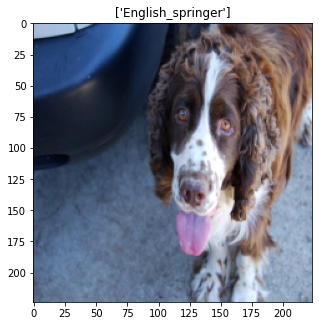

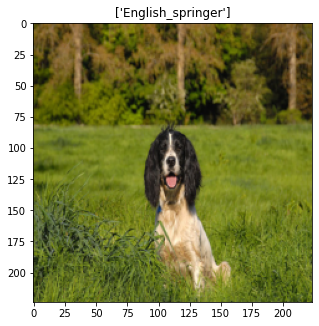


Accuracy of test text: 100.000000 %


In [15]:
eval(
    model=model,
    viz=True,
    dataset=subset,
    loader=subset, 
    verbose=True,
)

**Attack on subset**

Attack Image & Predicted Label


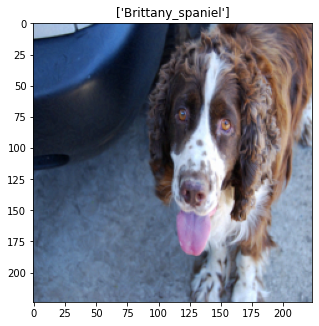

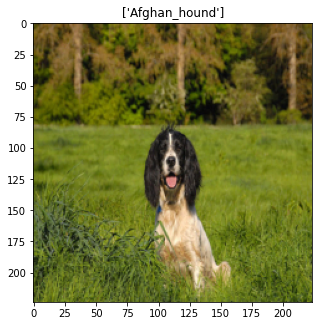


Accuracy of test text: 0.000000 %
Avg attack time is: 1.000000 


In [16]:
attack(
    model=model,
    viz=True,
    dataset=subset,
    loader=subset,
    eps=0.007,
    verbose=True,
)

#### **On all data**

**Evaluate on all data**

In [18]:
eval(
    model=model,
    viz=False,
    dataset=imgnet_dataset,
    loader=imgnet_dataloader, 
    verbose=True,
)

True Image & Predicted Label



Accuracy of test text: 64.885416 %


**Attack on all data**

In [19]:
attack(
    model=model,
    viz=False,
    dataset=imgnet_dataset,
    loader=imgnet_dataloader,
    eps=0.007,
    verbose=True,
)

Attack Image & Predicted Label



Accuracy of test text: 0.000000 %
Avg attack time is: 1.091668 


## **Blackbox attack**

### **Inspired**

**Create model**

In [20]:
model_attack = torch_models.densenet121(pretrained=True).to(device)
model_target = torch_models.googlenet(pretrained=True).to(device)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


#### **On subset**

True Image & Predicted Label


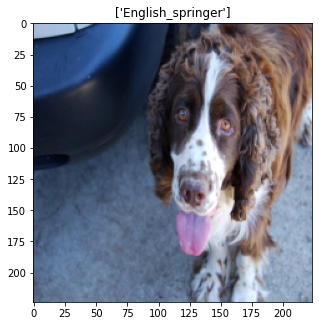

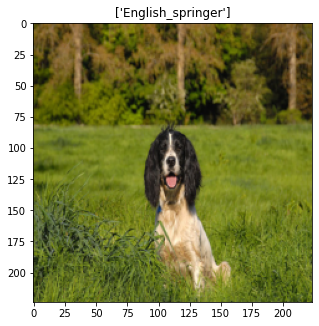


Accuracy of test text: 100.000000 %


In [21]:
eval(
    model=model_target,
    viz=True,
    dataset=subset,
    loader=subset, 
    verbose=True,
)

**Attack on subset**

Attack Image & Predicted Label


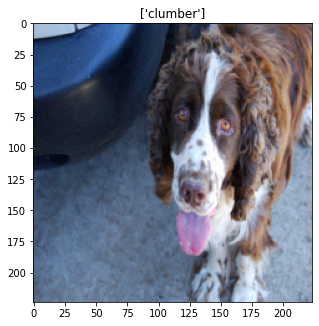

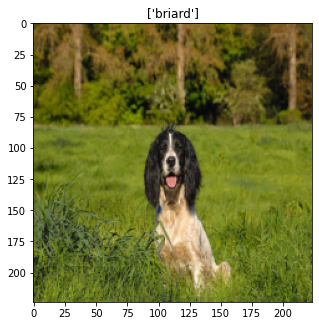


Accuracy of test text: 0.000000 %
Avg attack time is: 1.000000 


In [22]:
attack_batchs = attack(
    model=model_attack,
    viz=True,
    dataset=subset,
    loader=subset,
    return_batch_ls=True,
    eps = 0.01,
    verbose=True,
)

**Evaluate on target model**

True Image & Predicted Label


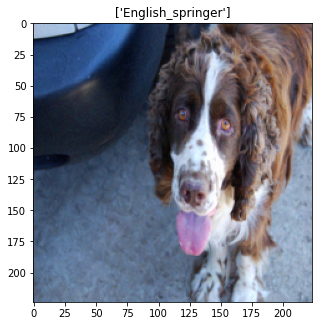

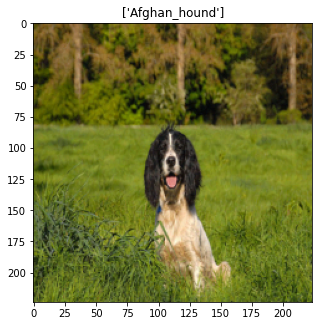


Accuracy of test text: 50.000000 %


In [23]:
eval(
    model=model_target,
    viz=True,
    dataset=attack_batchs,
    loader=attack_batchs, 
    verbose=True,
)

#### **All data**

In [24]:
attack_batchs = attack(
    model=model_attack,
    viz=False,
    dataset=imgnet_dataset,
    loader=imgnet_dataloader,
    verbose=True,
    eps = 0.01,
    return_batch_ls=True,
)

Attack Image & Predicted Label



Accuracy of test text: 0.000000 %
Avg attack time is: 1.058929 


In [25]:
eval(
    model=model_target,
    viz=False,
    dataset=attack_batchs,
    loader=attack_batchs, 
    verbose=True,
)

True Image & Predicted Label



Accuracy of test text: 56.151653 %


### **Ensemble attack**

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models as torch_models


class FusionModel(nn.Module):
    """Some Information about FusionModel"""

    def __init__(
        self, device="cpu", pretrained=True, multi_lbls=False,
    ):
        super().__init__()
        self.model_ls = [
            torch_models.densenet121(pretrained=pretrained).to(device),
            torch_models.resnet101(pretrained=pretrained).to(device),
            torch_models.vgg16(pretrained=pretrained).to(device),
        ]
        self.multi_lbls = multi_lbls
        for i, _ in enumerate(self.model_ls):
            self.model_ls[i].eval()
    def forward(self, x):
        if self.multi_lbls:
            res = [
                torch.softmax(model(x), dim=1) for model in self.model_ls
            ]
            res = torch.cat(res, dim=0)
        else:
            res = [
                torch.softmax(model(x), dim=1).unsqueeze(dim=1) for model in self.model_ls
            ]
            res = torch.cat(res, dim=1).mean(dim=1)
        return res

**Create model**

In [27]:
model_attack = FusionModel(pretrained=True, device = device, multi_lbls=True).to(device)
model_target = torch_models.googlenet(pretrained=True).to(device)

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


#### **On subset**

**Evaluate attack model on subset**

True Image & Predicted Label


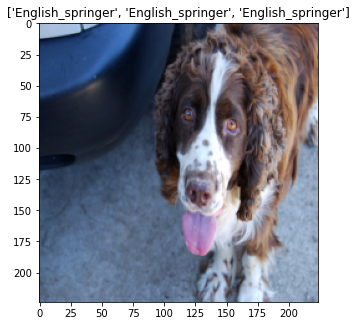

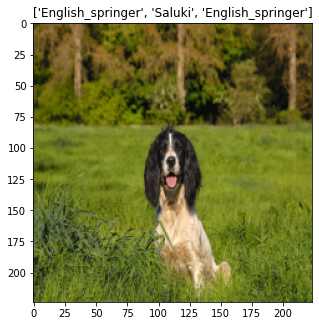


Accuracy of test text: 250.000000 %


In [28]:
eval(
    model=model_attack,
    viz=True,
    dataset=subset,
    loader=subset, 
    verbose=True,
)

**Evaluate target model on subset**

True Image & Predicted Label


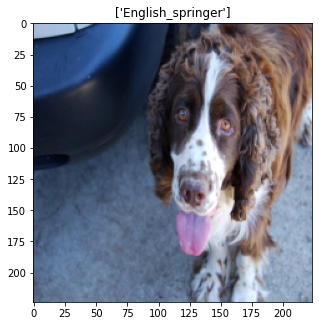

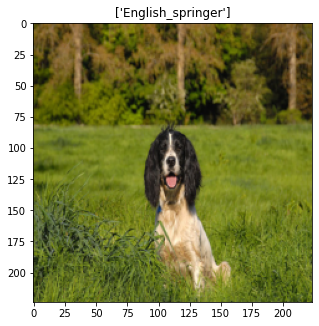


Accuracy of test text: 100.000000 %


In [29]:
eval(
    model=model_target,
    viz=True,
    dataset=subset,
    loader=subset, 
    verbose=True,
)

**Attack on subset**

Attack Image & Predicted Label


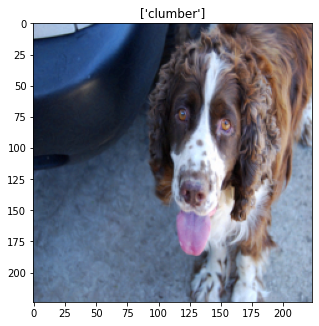

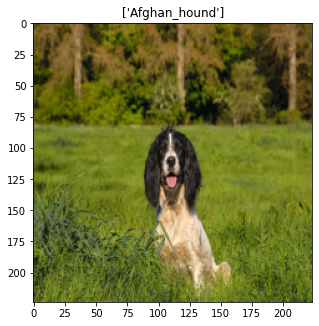


Accuracy of test text: 0.000000 %
Avg attack time is: 1.000000 


In [30]:
model_attack.multi_lbls = False
attack_batchs = attack(
    model=model_attack,
    viz=True,
    dataset=subset,
    loader=subset,
    return_batch_ls=True,
    verbose=True,
)

True Image & Predicted Label


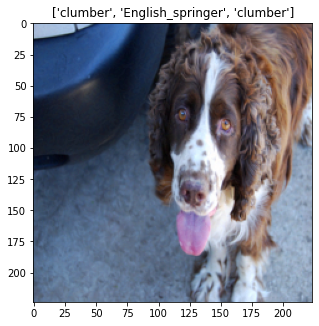

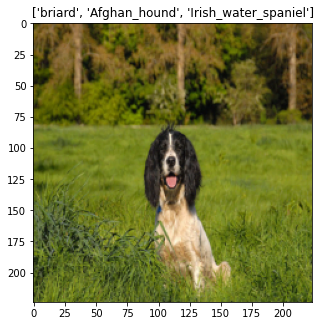


Accuracy of test text: 50.000000 %


In [31]:
model_attack.multi_lbls = True
eval(
    model=model_attack,
    viz=True,
    dataset=attack_batchs,
    loader=attack_batchs, 
    verbose=True,
)

#### **On all data**

**Evaluate target model on all data**

In [32]:
eval(
    model=model_target,
    viz=False,
    dataset=imgnet_dataset,
    loader=imgnet_dataloader, 
    verbose=True,
)

True Image & Predicted Label



Accuracy of test text: 64.885416 %


**Evaluate attack model on all data**

In [33]:
model_attack.multi_lbls = False
eval(
    model=model_attack,
    viz=False,
    dataset=imgnet_dataset,
    loader=imgnet_dataloader, 
    verbose=True,
)

True Image & Predicted Label



Accuracy of test text: 69.056923 %


**Attack on all data**

In [34]:
model_attack.multi_lbls = False
attack_batchs = attack(
    model=model_attack,
    viz=False,
    dataset=imgnet_dataset,
    loader=imgnet_dataloader,
    verbose=True,
    eps = 0.1,
    return_batch_ls=True,
)

Attack Image & Predicted Label



Accuracy of test text: 0.000000 %
Avg attack time is: 1.070018 


**Evaluate target model on attacked data**

In [35]:
eval(
    model=model_target,
    viz=False,
    dataset=attack_batchs,
    loader=attack_batchs, 
    verbose=True,
)

True Image & Predicted Label



Accuracy of test text: 8.659837 %
